<a href="https://colab.research.google.com/github/jfahadi/Android-Project/blob/master/federateImg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tensorflow tensorflow-federated



  Using cached tensorflow_federated-0.87.0-py3-none-manylinux_2_31_x86_64.whl.metadata (19 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached dp_accounting-0.4.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached google_vizier-0.1.11-py3-none-any.whl.metadata (10 kB)
  Using cached jaxlib-0.4.14-cp310-cp310-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached jax-0.4.14.tar.gz (1.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version

Import Libraries

In [14]:
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow.keras import layers, models
import numpy as np
import os
from tensorflow_federated.python.learning import algorithms
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

Load and preprocess datasets

In [2]:
# Load datasets (e.g., NIH Chest X-ray or BraTS datasets)
def load_and_preprocess_data():
    # Example: Load and normalize dummy data (replace with actual dataset)
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)  # Add channel
    return (x_train, y_train), (x_test, y_test)

# Split data for multiple institutions
def simulate_institution_data(x_train, y_train, num_institutions=5):
    data_per_institution = len(x_train) // num_institutions
    institutions_data = [
        (x_train[i * data_per_institution:(i + 1) * data_per_institution],
         y_train[i * data_per_institution:(i + 1) * data_per_institution])
        for i in range(num_institutions)
    ]
    return institutions_data

(x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
institution_data = simulate_institution_data(x_train, y_train)


11490434/11490434 [==============================] - 0s 0us/step


Define Model Architecture using CNN

In [3]:
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')  # Adjust for real dataset
    ])
    return model


Implement Federated Learning Framework using tff

In [4]:
def model_fn():
    model = create_cnn_model()
    # Remove the model.compile call here

    # Create a sample dataset for input_spec
    # Assuming the first element of institution_data is representative
    sample_dataset = tf.data.Dataset.from_tensor_slices({
        'x': institution_data[0][0],
        'y': institution_data[0][1]
    }).batch(32)

    return tff.learning.models.from_keras_model(
        model,
        input_spec=sample_dataset.element_spec, # Use element_spec of sample dataset
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
# Convert institution data into federated data
def create_federated_data(institution_data):
    federated_data = []
    for x, y in institution_data:
        dataset = tf.data.Dataset.from_tensor_slices({'x': x, 'y': y})
        dataset = dataset.batch(32)  # Batch size for processing
        federated_data.append(dataset)
    return federated_data

federated_data = create_federated_data(institution_data)


# Define Federated Averaging Process

iterative_process = algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialize and train
state = iterative_process.initialize()
NUM_ROUNDS = 10
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_num}, Metrics: {metrics}')


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.5826667), ('loss', 1.4466687), ('num_examples', 60000), ('num_batches', 1875)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8855), ('loss', 0.3800465), ('num_examples', 60000), ('num_batches', 1875)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.91966665), ('loss', 0.26770964), ('num_examples', 60000), ('num_batches', 1875)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('

**Implement differential privacy and secure aggregation. additional privacy**

In [5]:
def create_dp_optimizer():
    # Create the DP optimizer
    dp_optimizer = DPKerasSGDOptimizer(
        l2_norm_clip=1.0,
        noise_multiplier=0.5,
        num_microbatches=1,
        learning_rate=0.01
    )

    # Wrap the DP optimizer in a function to compute and apply gradients
    def client_optimizer(model):  # model argument is required here
        def compute_apply_dp_gradients(tape, loss, weights):
            # Compute DP gradients
            gradients = tape.gradient(loss, weights)

            # Apply DP gradients to the optimizer
            dp_optimizer.apply_gradients(zip(gradients, weights))

        return compute_apply_dp_gradients

    return client_optimizer



**Modify the iterative process**

In [6]:
# Define optimizer functions
client_optimizer_fn = lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=1.0)

# Build the Federated Averaging algorithm
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=client_optimizer_fn,
    server_optimizer_fn=server_optimizer_fn
)



**Evaluate Model Performance compare with centralized training**

In [7]:
def centralized_training(x_train, y_train, x_test, y_test):
    model = create_cnn_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Centralized Model - Loss: {loss}, Accuracy: {accuracy}')

centralized_training(x_train, y_train, x_test, y_test)


Epoch 1/10
1500/1500 [==============================] - 66s 43ms/step - loss: 0.1400 - accuracy: 0.9573 - val_loss: 0.0619 - val_accuracy: 0.9827
Epoch 2/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0474 - accuracy: 0.9851 - val_loss: 0.0590 - val_accuracy: 0.9827
Epoch 3/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0311 - accuracy: 0.9901 - val_loss: 0.0381 - val_accuracy: 0.9899
Epoch 4/10
1500/1500 [==============================] - 62s 42ms/step - loss: 0.0223 - accuracy: 0.9932 - val_loss: 0.0457 - val_accuracy: 0.9871
Epoch 5/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0166 - accuracy: 0.9943 - val_loss: 0.0447 - val_accuracy: 0.9881
Epoch 6/10
1500/1500 [==============================] - 71s 47ms/step - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.0499 - val_accuracy: 0.9878
Epoch 7/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0412 -

**Analyze and Document Results for visualisation**

> Add blockquote



Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.89101666), ('loss', 0.36167285), ('num_examples', 60000), ('num_batches', 1875)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9644), ('loss', 0.11773191), ('num_examples', 60000), ('num_batches', 1875)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9766), ('loss', 0.07696378), ('num_examples', 60000), ('num_batches', 1875)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('f

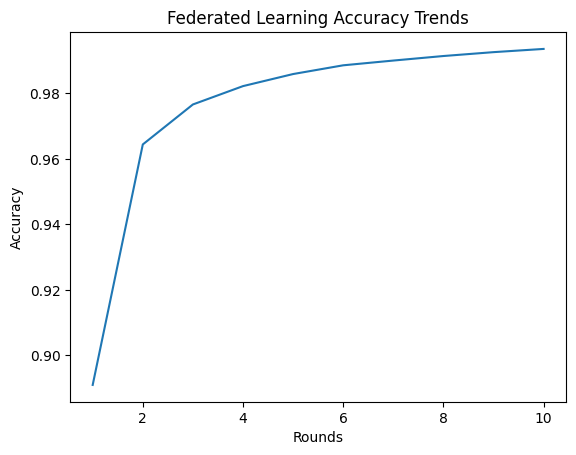

In [12]:
# Example: Plot accuracy trends over federated rounds
rounds = range(1, NUM_ROUNDS + 1)

# Initialize an empty list to store accuracy values
accuracy = []

# Re-run the federated training loop to capture metrics for each round
state = iterative_process.initialize()
for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_data)
    print(f'Round {round_num}, Metrics: {metrics}')

    # Extract sparse_categorical_accuracy from the nested metrics dictionary
    accuracy_value = metrics['client_work']['train']['sparse_categorical_accuracy']
    accuracy.append(accuracy_value)  # Append the accuracy value

# Plot the accuracy trends
#import matplotlib.pyplot as plt

plt.plot(rounds, accuracy)
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Federated Learning Accuracy Trends')
plt.show()


NameError: name 'test_images' is not defined

**save model**

In [ ]:
# Save the model to a file
#rnn_model.save("global_cnn_model.h5")
#print("Model saved to 'global_rnn_model.h5'")